In [1]:
# import required packages

# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# Data Transformation
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline

# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict, GridSearchCV

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve

# %matplotlib inline

# Visualizing Composite Estimators
# from sklearn import set_config
# set_config(display='diagram')

# Tensorflow
import tensorflow as tf

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.test.is_built_with_cuda()

True

In [39]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv

df['label'] = df['label'] -1 

dict_class_names = {0: 'Tumor', 1:'Stroma', 2:'Complex', 3:'Lymphoma', 4:'Debris', 5:'Mucosa', 6:'Adipose', 7:'Empty'}
df['label_name'] = df['label'].map(dict_class_names)
class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [43]:
X = (df.loc[:, (df.columns != 'label') & (df.columns != 'label_name')].values)/255
y = (df.loc[:, (df.columns == 'label')].values)

In [44]:
X = np.reshape(X, (5000, 64,64))

In [45]:
# Sanity check: 
print(f'Is the length of X, X_extracted & Y equal? It should be: {len(X) == len(y)}')

Is the length of X, X_extracted & Y equal? It should be: True


In [46]:
# Split Data into test & Train: 
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
# Build pipeline for SGD:
pipe_SGD = Pipeline([('scaler', StandardScaler()), ('sgd', SGDClassifier())])

In [13]:
pipe_SGD.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('scaler', StandardScaler()), ('sgd', SGDClassifier())])

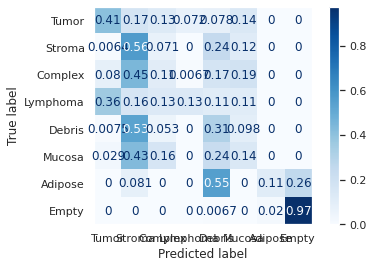

In [9]:
plot_confusion_matrix(estimator=pipe_SGD, X=X_test, y_true=y_test, cmap=plt.cm.Blues, normalize='true', display_labels=class_names)
plt.grid(False)

In [162]:
clf_svm = svm.SVC(kernel='rbf', gamma='auto', C=0.9) # default params to begin with
# clf_svm_ex = svm.LinearSVC()
clf_svm.fit(X_train, y_train)
# clf_svm_ex.fit(X_train_ex, y_train_ex)

SVC(C=0.9, gamma='auto')

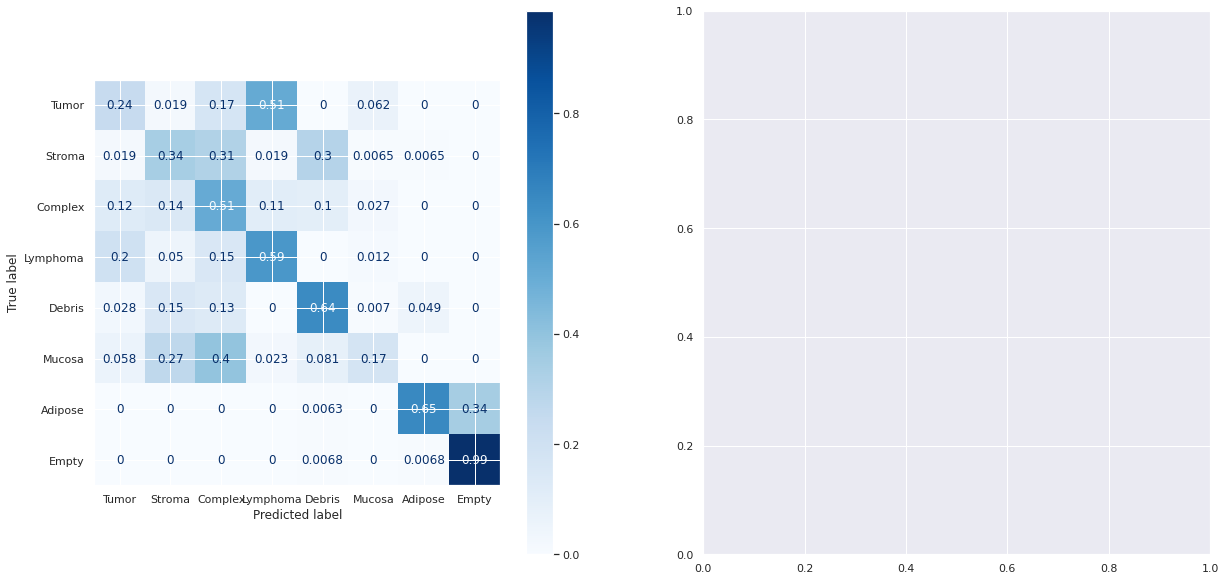

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
plot_confusion_matrix(estimator=clf_svm, X=X_test, y_true=y_test, cmap=plt.cm.Blues, normalize='true', display_labels=class_names, ax=axes[0])
# plot_confusion_matrix(estimator=clf_svm_ex, X=X_test_ex, y_true=y_test_ex, cmap=plt.cm.Blues, normalize='true', display_labels=class_names, ax=axes[1])

In [ ]:
clf_gnb = GaussianNB()
clf_knn = KNeighborsClassifier(n_jobs=-1)

In [ ]:
clf_gnb.fit(X_train, y_train)
clf_knn.fit(X_train, y_train)

In [ ]:
# pred_gnb = confusion_matrix(y_test, clf_gnb.predict(X_test))
# pred_knn = confusion_matrix(y_test, clf_knn.predict(X_test))

In [62]:
from tensorflow.keras import layers, models

In [77]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))


In [78]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        36928     
Total params: 74,496
Trainable params: 74,496
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8))

In [80]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [82]:
X_train.shape

(3750, 64, 64)

In [97]:
x_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
x_test = X_test.reshape(X_test.shape[0], 64, 64, 1)

In [102]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
118/118 [==============================] - 17s 144ms/step - loss: 0.6590 - accuracy: 0.7483 - val_loss: 0.7507 - val_accuracy: 0.7120
Epoch 2/10
118/118 [==============================] - 17s 141ms/step - loss: 0.5944 - accuracy: 0.7725 - val_loss: 0.7529 - val_accuracy: 0.7120
Epoch 3/10
118/118 [==============================] - 17s 144ms/step - loss: 0.5835 - accuracy: 0.7741 - val_loss: 0.9674 - val_accuracy: 0.6488
Epoch 4/10
118/118 [==============================] - 18s 151ms/step - loss: 0.5716 - accuracy: 0.7789 - val_loss: 0.6864 - val_accuracy: 0.7504
Epoch 5/10
118/118 [==============================] - 18s 149ms/step - loss: 0.5138 - accuracy: 0.8117 - val_loss: 0.6596 - val_accuracy: 0.7432
Epoch 6/10
118/118 [==============================] - 17s 142ms/step - loss: 0.5127 - accuracy: 0.8027 - val_loss: 0.7884 - val_accuracy: 0.7168
Epoch 7/10
118/118 [==============================] - 17s 142ms/step - loss: 0.4774 - accuracy: 0.8184 - val_loss: 0.6815 - val_ac

40/40 - 1s - loss: 0.7216 - accuracy: 0.7144


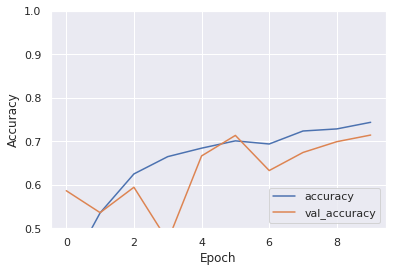

In [101]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)